In [240]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [241]:
# Load datasets
jobs_df = pd.read_csv(r"C:\Users\vidya\Topic Modelling_3020\Thematic_skillsNer.csv")
courses_df = pd.read_csv(r"C:\Users\vidya\Topic Modelling_3020\Thematic_course_outlines.csv")
unrelated_df = pd.read_csv(r"C:\Users\vidya\Topic Modelling_3020\extracted_skills_UnrelatedData.csv")


In [242]:
num_topics_dict = {
    'communications': 15, 
    'computer': 12, 
    'controls': 20,
    'electronics': 18,
    'power': 15, 
}


In [243]:
def print_top_words(model, num_words=10):
    for idx, topic in model.print_topics(-1, num_words=num_words):
        print(f"Topic {idx}: {topic}\n")

In [244]:
def compute_closeness(docs, dictionary, lda_model):
    total_similarity = 0
    doc_count = 0
    
    for doc in docs:
        # Convert document to bag-of-words representation
        bow = dictionary.doc2bow(doc)
        if not bow:  # Skip empty documents
            continue
            
        # Initialize a dictionary to store the summed probabilities for each topic
        topic_scores = {topic_id: 0 for topic_id in range(lda_model.num_topics)}  # Initialize topic scores
        
        # Loop over each topic in the model (baseline topics T)
        for topic_id in range(lda_model.num_topics):
            # Get the words in this topic
            topic_words = lda_model.get_topic_terms(topic_id, topn=len(dictionary)) 
            
            # Sum the probabilities of words in the topic that appear in the document
            topic_score = 0
            for word_id, prob in topic_words:
                word = dictionary[word_id]  # Get word from ID
                if word in [dictionary[word_id] for word_id, _ in bow]:  # Check if the word is in the document
                    # Sum the probability of this word (multiply by word frequency)
                    word_prob = prob * dict(bow).get(word_id, 0)
                    topic_score += word_prob
            
            topic_scores[topic_id] = topic_score
        
        # For each document, choose the topic with the highest summed probability
        max_topic_score = max(topic_scores.values())
        total_similarity += max_topic_score  # Add the highest score to total similarity
        doc_count += 1  # Count the number of documents processed
    
    # Return the average similarity (closeness) if documents are present
    return total_similarity / doc_count if doc_count > 0 else 0.0

In [245]:
results = []

# Process each thematic area
for thematic, num_topics in num_topics_dict.items():
    print(f"\n{'='*50}")
    print(f"Processing Thematic Area: {thematic.upper()}")
    print(f"{'='*50}\n")
    
    # Step 1: Train LDA on SU (Jobs) to get base topics T

    print("Generating Base Topics (T) from SU Corpus")
    
    su_docs = jobs_df[jobs_df['Thematic'] == thematic]['cleaned_description']

    # Handle missing values: drop rows where 'cleaned_description' is NaN
    su_docs = su_docs.dropna()

    # Ensure all descriptions are in string format (convert any non-string values to empty string if needed)
    su_docs = su_docs.astype(str)

    # Now split the descriptions into words (assuming they are comma-separated)
    su_docs = [doc.split(", ") for doc in su_docs]

    # Create dictionary and corpus
    dictionary = corpora.Dictionary(su_docs)
    dictionary.filter_extremes(no_below=1, no_above=0.95)
    su_corpus = [dictionary.doc2bow(doc) for doc in su_docs]

    
    # Train LDA model
    lda = LdaModel(
        su_corpus,
        num_topics=num_topics,
        id2word=dictionary,
        random_state=42,
        passes=50
    )
    
    # Print base topics
    print(f"\nGenerated {num_topics} Base Topics (T):")
    print_top_words(lda)

      # Step 2: Compute C(JD) (Closeness between JD and JD Topics)

    print("Computing C(JD) (Closeness between JD and JD Topics)")
    jd1_docs = jobs_df[jobs_df['Thematic'] == thematic]['cleaned_description']
    jd1_docs = jd1_docs.dropna()  # Remove any NaN values
    jd1_docs = jd1_docs.astype(str)  # Ensure all descriptions are strings
    jd1_docs = [doc.split(", ") for doc in jd1_docs]
    c_jd = compute_closeness(jd1_docs, dictionary, lda)
    print(f"C(JD) = {c_jd:.4f} (Closeness between JD and JD Topics)")
    

    # Step 3: Compare Course Syllabi (CS) to JD Topics (C(CS))

    print("Computing C(CS) (Closeness between Course Syllabi (CS) and JD Topics)")
    cs_docs = courses_df[courses_df['Thematic'] == thematic]['cleaned_description']
    #cs_docs = cs_docs.dropna()  # Remove any NaN values
    cs_docs = cs_docs.astype(str)  # Ensure all descriptions are strings
    cs_docs = [doc.split(", ") for doc in cs_docs]
    c_cs = compute_closeness(cs_docs, dictionary, lda)
    print(f"C(CS) = {c_cs:.4f} (Closeness between CS and JD Topics)")
    

    # Step 4: Compare Random Unrelated (RU) to JD Topics (C(RU))
    print("Computing C(RU) (Closeness between Unrelated and JD Topics)")
    ru_docs = unrelated_df['cleaned_description']
    ru_docs = ru_docs.dropna()  # Remove any NaN values
    ru_docs = ru_docs.astype(str)  # Ensure all descriptions are strings
    ru_docs = [doc.split(", ") for doc in ru_docs]
    c_ru = compute_closeness(ru_docs, dictionary, lda)
    print(f"C(RU) = {c_ru:.4f} (Closeness between Unrelated and JD Topics)")
    
    # Step 5: Compute Alignment Metric (rho)
    if (c_jd - c_ru) != 0:
        rho = (c_cs - c_ru) / (c_jd - c_ru)
    else:
        rho = 0.0
    
    print(f"\nFinal Alignment Metric (rho) = {rho:.4f}")
    print(f"Interpretation: {'Strong alignment' if rho > 0.7 else 'Needs improvement'}")
    print("\n" + "="*50 + "\n")

    # Store results in a list
    results.append([thematic, c_jd, c_cs, c_ru, rho])




Processing Thematic Area: COMMUNICATIONS

Generating Base Topics (T) from SU Corpus

Generated 15 Base Topics (T):
Topic 0: 0.031*"infrastructure" + 0.023*"information security" + 0.016*"firewalls" + 0.016*"manage" + 0.016*"management" + 0.013*"operating system" + 0.013*"system software" + 0.013*"security system" + 0.013*"identity management" + 0.013*"install"

Topic 1: 0.035*"troubleshooting" + 0.021*"installation" + 0.014*"technical documentation" + 0.013*"commissioning" + 0.011*"system diagrams" + 0.011*"systems systems" + 0.011*"integration" + 0.011*"host" + 0.011*"fiber optic" + 0.011*"fiber coaxial"

Topic 2: 0.027*"service desk" + 0.020*"installation" + 0.020*"service delivery" + 0.016*"infrastructure" + 0.012*"troubleshooting" + 0.008*"jenkins" + 0.008*"information technology" + 0.008*"support business" + 0.008*"python" + 0.008*"solutions microsoft"

Topic 3: 0.027*"citrix" + 0.024*"certified professional" + 0.024*"manage" + 0.020*"best practices" + 0.016*"cloud platforms" + 0

In [246]:
# Convert results to a Pandas DataFrame
df_results = pd.DataFrame(results, columns=['Thematic Area', 'C(JD)', 'C(CS)', 'C(RU)', 'rho'])

# Print summary table
print("\nSummary of Closeness Scores and Alignment Metrics:")
print(df_results.to_string(index=False))


Summary of Closeness Scores and Alignment Metrics:
 Thematic Area    C(JD)    C(CS)    C(RU)      rho
communications 0.428480 0.164422 0.034141 0.330378
      computer 0.191302 0.169337 0.033010 0.861233
      controls 0.579471 0.612855 0.056302 1.063811
   electronics 0.383174 0.375270 0.041647 0.976856
         power 0.367047 0.349810 0.030715 0.948751


Computer went with 2nd highest coherence score 16 for a better alignment - 0.759556 
Optimal Score for : Controls 20 and electronics 18
Power: 2nd Lowest coherence Score 15 topics 0.948751
Communications: optimal Score 19 - 0.289146

In [247]:
# Compute overall weighted rho
total_jds = 0
weighted_rho_sum = 0

for thematic, c_jd, c_cs, c_ru, rho in results:
    num_jds = jobs_df[jobs_df['Thematic'] == thematic].shape[0]  # Count JDs in thematic area
    if num_jds > 0:  # Ensure we have job descriptions
        weighted_rho_sum += rho * num_jds  # Weighted sum of rho
        total_jds += num_jds  # Total count of JDs

# Compute final weighted rho
overall_rho = weighted_rho_sum / total_jds if total_jds > 0 else 0.0

print(f"\nOverall Weighted Alignment Metric (rho) = {overall_rho:.4f}")



Overall Weighted Alignment Metric (rho) = 0.8039


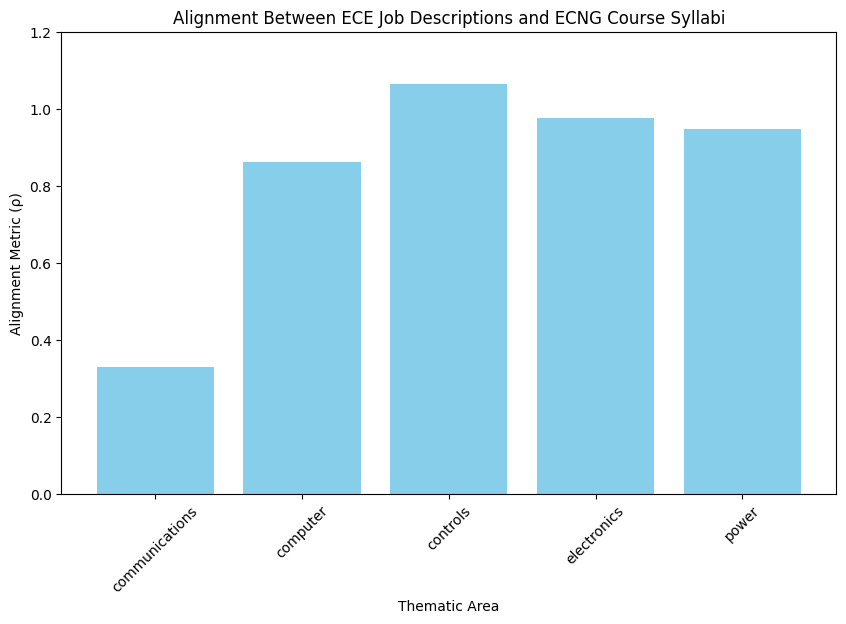

In [248]:
# Plot the alignment metric (rho) for each thematic area
plt.figure(figsize=(10, 6))
plt.bar(df_results["Thematic Area"], df_results["rho"], color='skyblue')

# Add labels and title
plt.xlabel("Thematic Area")
plt.ylabel("Alignment Metric (ρ)")
plt.title("Alignment Between ECE Job Descriptions and ECNG Course Syllabi")

# Set y-axis limits
plt.ylim(0, 1.2)  

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

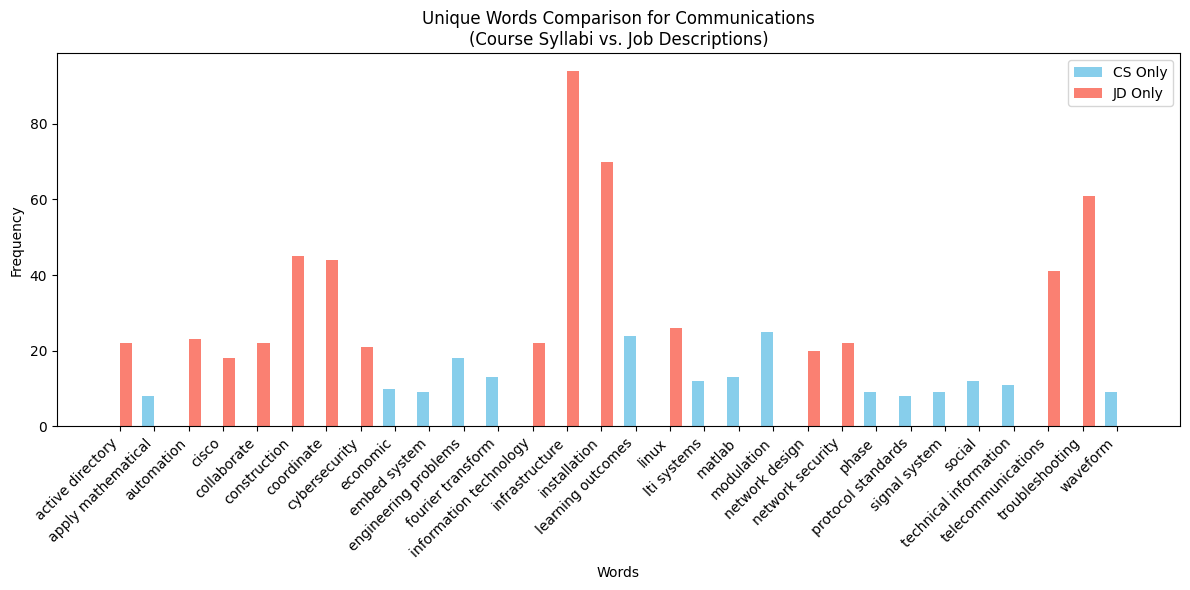

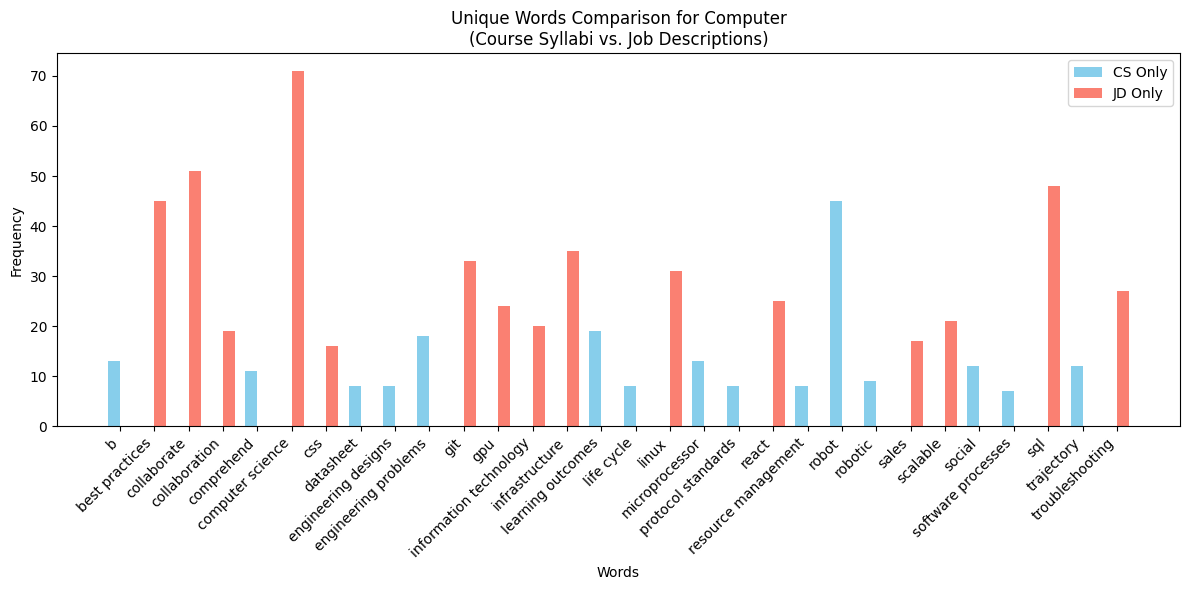

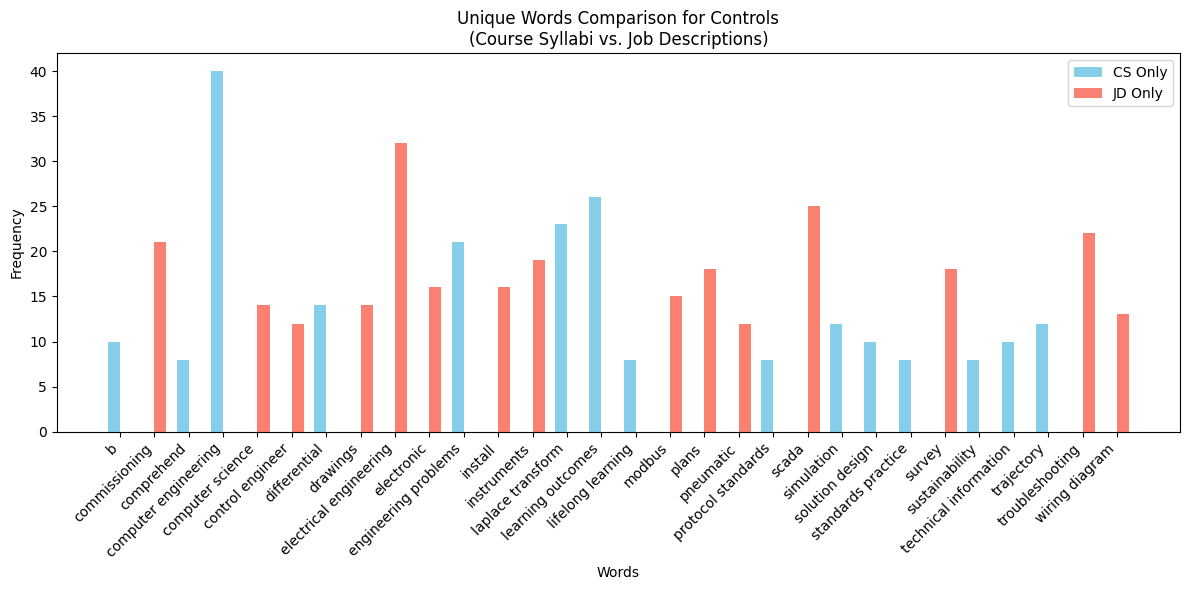

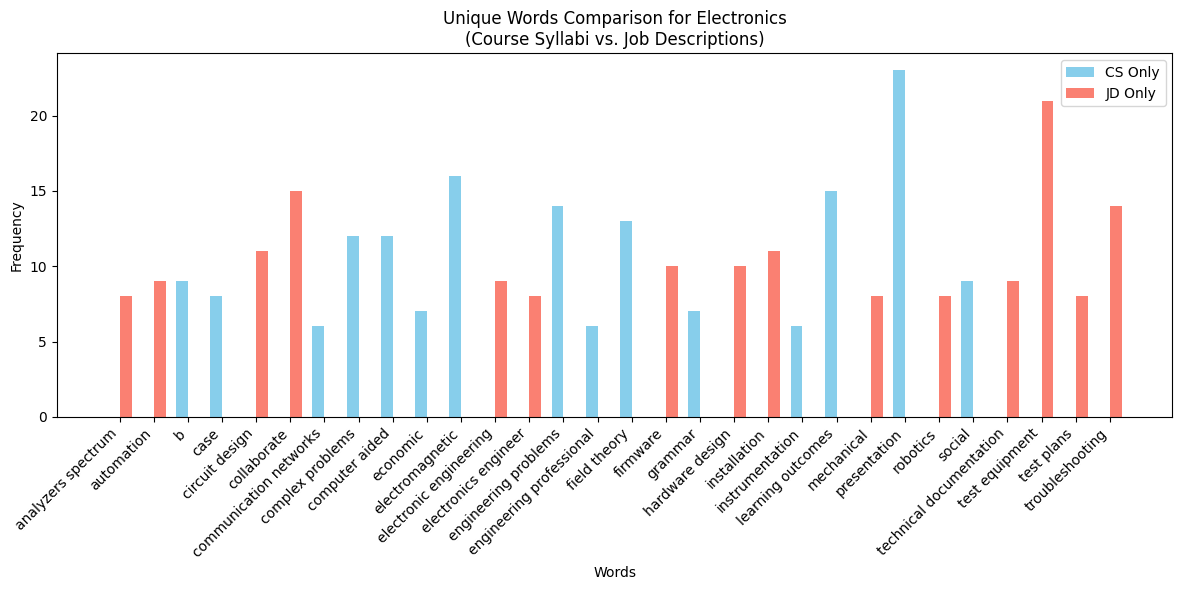

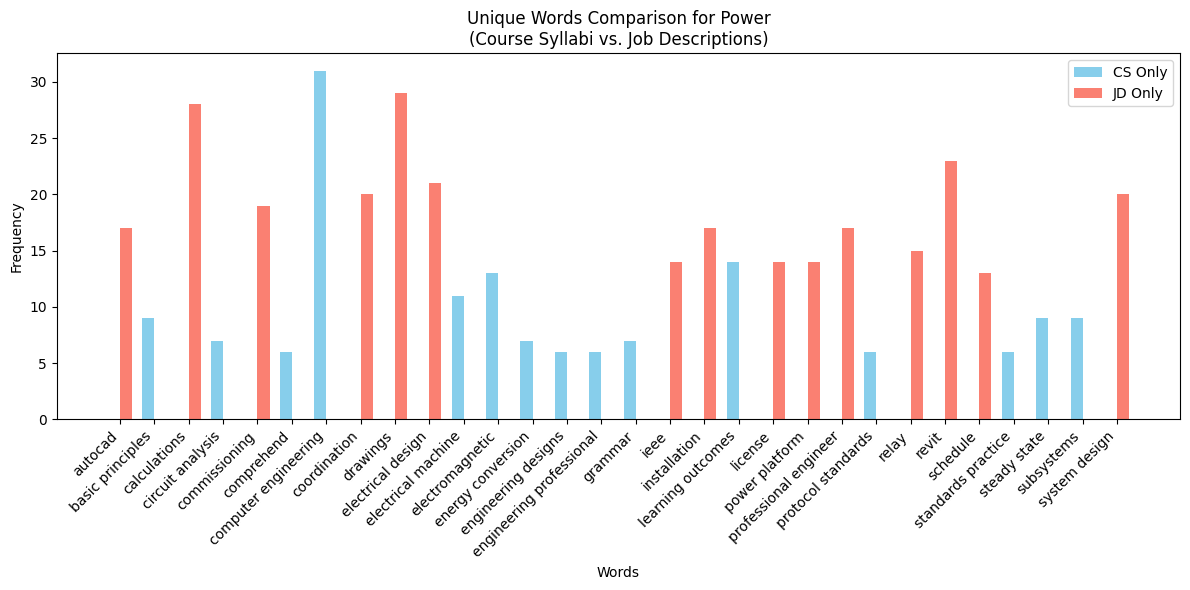

In [250]:
# List of thematic areas (from your num_topics_dict keys)
thematic_list = list(num_topics_dict.keys())

# Loop over each thematic area
for thematic in thematic_list:
    # Extract and process words for JD
    jd_docs = jobs_df[jobs_df['Thematic'] == thematic]['cleaned_description'].dropna().astype(str)
    jd_words = jd_docs.str.split(", ").explode().tolist()
    jd_set = set(jd_words)
    
    # Extract and process words for CS
    cs_docs = courses_df[courses_df['Thematic'] == thematic]['cleaned_description'].dropna().astype(str)
    cs_words = cs_docs.str.split(", ").explode().tolist()
    cs_set = set(cs_words)
    
    # Find words unique to each dataset
    jd_only = jd_set - cs_set   # Words in JD but not in CS
    cs_only = cs_set - jd_set   # Words in CS but not in JD
    
    # Count frequencies for unique words in JD and CS
    jd_only_counts = Counter([word for word in jd_words if word in jd_only])
    cs_only_counts = Counter([word for word in cs_words if word in cs_only])
    
    # Convert counts to DataFrames, selecting top 10 words for each
    jd_only_df = pd.DataFrame(jd_only_counts.items(), columns=['Word', 'Frequency']) \
                    .sort_values(by='Frequency', ascending=False).head(15)
    cs_only_df = pd.DataFrame(cs_only_counts.items(), columns=['Word', 'Frequency']) \
                    .sort_values(by='Frequency', ascending=False).head(15)
    
    # Create a union of the words (top words from both sets)
    all_words = list(set(jd_only_df['Word']).union(set(cs_only_df['Word'])))
    all_words.sort()  # Sort alphabetically for consistency
    
    # Get frequencies for each word from both JD and CS unique counts
    jd_freq = [jd_only_counts.get(word, 0) for word in all_words]
    cs_freq = [cs_only_counts.get(word, 0) for word in all_words]
    
    # Set up positions for grouped bars
    x = np.arange(len(all_words))
    width = 0.35
    
 
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, cs_freq, width, label='CS Only', color='skyblue')
    plt.bar(x + width/2, jd_freq, width, label='JD Only', color='salmon')
    
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(f"Unique Words Comparison for {thematic.capitalize()}\n(Course Syllabi vs. Job Descriptions)")
    plt.xticks(x, all_words, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


--------------------------------------------------
Thematic Area: COMMUNICATIONS
--------------------------------------------------
                Word  JD Frequency  CS Frequency  Frequency Difference
              manage            39             1                    38
                plan            29            10                    19
communication system            22            20                     2
            managing            22             1                    21
       communication            20            19                     1
  project management            20             3                    17
          management            18             6                    12
   technical writing            14             1                    13
         integration            14             3                    11
communication skills            13             1                    12
          electrical            12            45                   -33
      communica

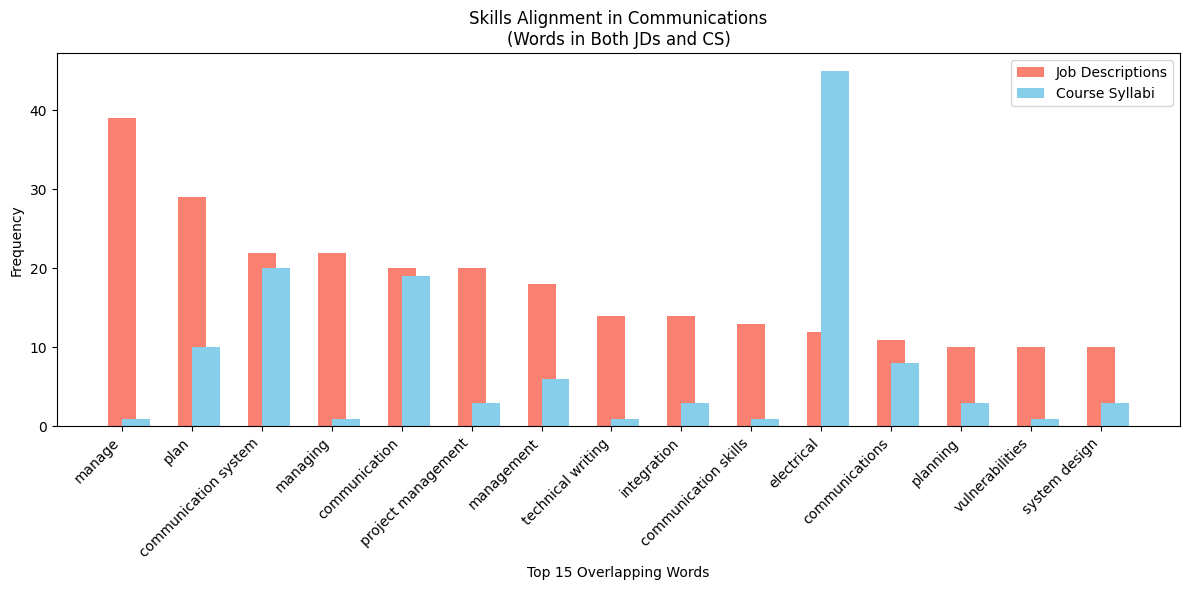


--------------------------------------------------
Thematic Area: COMPUTER
--------------------------------------------------
                 Word  JD Frequency  CS Frequency  Frequency Difference
               python            75             1                    74
 software development            51             3                    48
 communication skills            42             1                    41
                 java            40             1                    39
                    c            34            12                    22
 software engineering            30             2                    28
          reliability            20             1                    19
         professional            19            10                     9
          integration            18             2                    16
                write            17             3                    14
 computer engineering            17            36                   -19
         

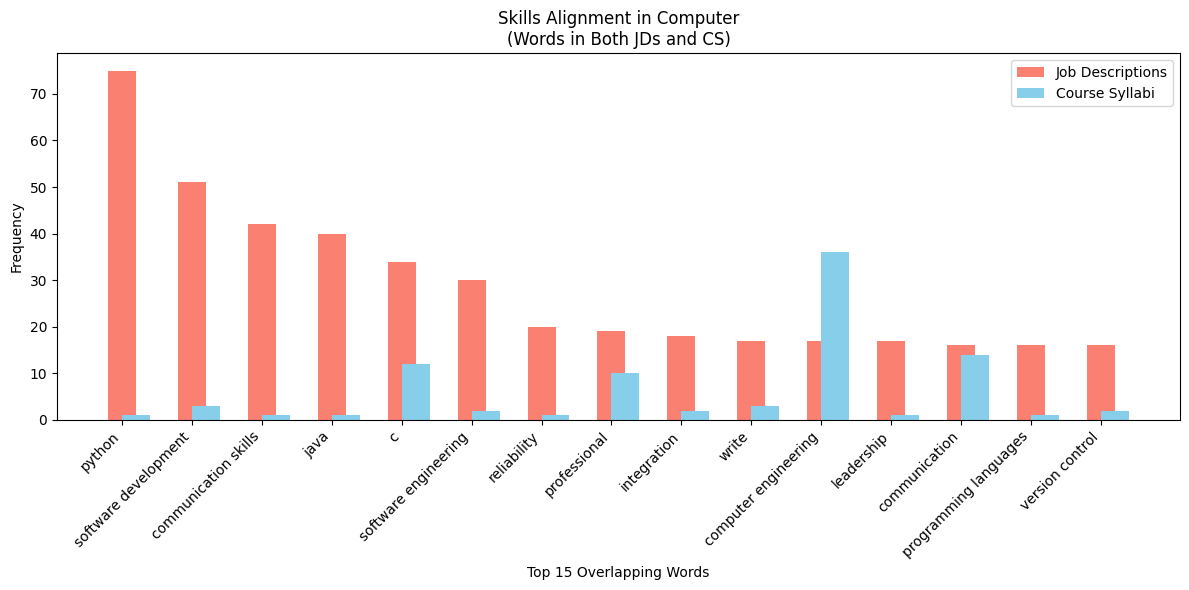


--------------------------------------------------
Thematic Area: CONTROLS
--------------------------------------------------
                Word  JD Frequency  CS Frequency  Frequency Difference
      control system            74            37                    37
          electrical            72            42                    30
                 plc            47             3                    44
         programming            33             3                    30
     instrumentation            32            16                    16
communication skills            24             1                    23
       communication            15            12                     3
  project management            14             3                    11
            planning            13             5                     8
     control systems            13             3                    10
          automation            12             2                    10
        construction 

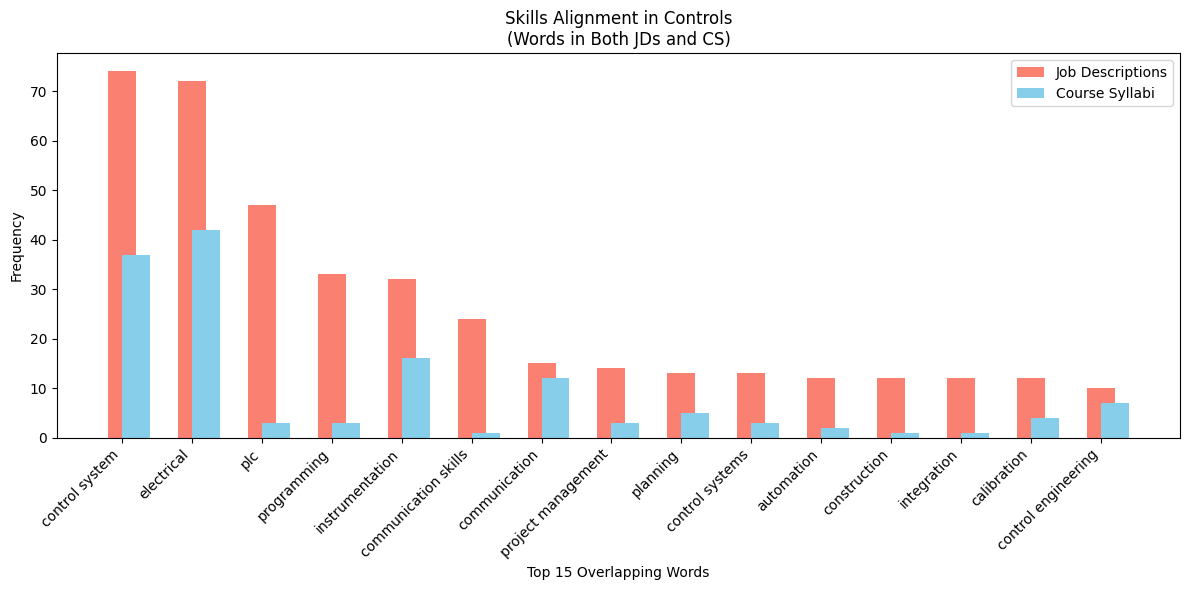


--------------------------------------------------
Thematic Area: ELECTRONICS
--------------------------------------------------
                  Word  JD Frequency  CS Frequency  Frequency Difference
electrical engineering            31             2                    29
            electrical            29            37                    -8
           electronics            29             7                    22
                     c            17             2                    15
           integration            15             2                    13
  communication skills            14             1                    13
    electronic circuit            12             1                    11
              embedded            12             2                    10
           reliability            11             1                    10
        power supplies            10             4                     6
  electronic component             9             1                 

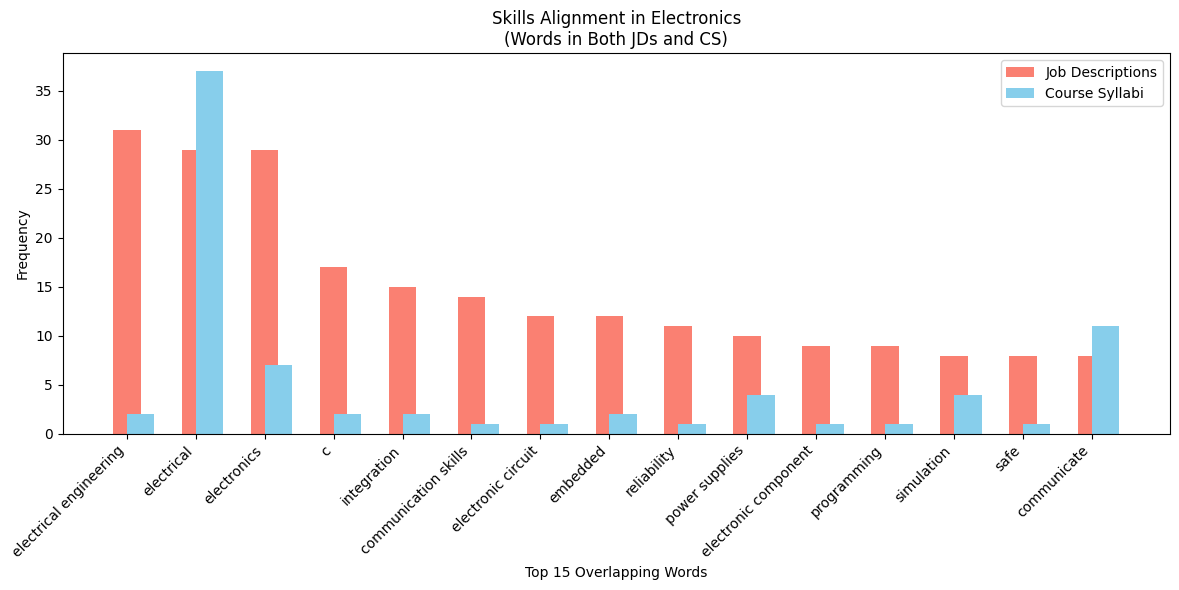


--------------------------------------------------
Thematic Area: POWER
--------------------------------------------------
                  Word  JD Frequency  CS Frequency  Frequency Difference
electrical engineering            97             1                    96
            electrical            84            41                    43
          construction            35             2                    33
  distribution systems            23             3                    20
     electrical system            21             1                    20
    industry standards            20             6                    14
              planning            16             3                    13
         power systems            16            17                    -1
          power system            15             8                     7
          high voltage            13             1                    12
    power distribution            13             1                    12


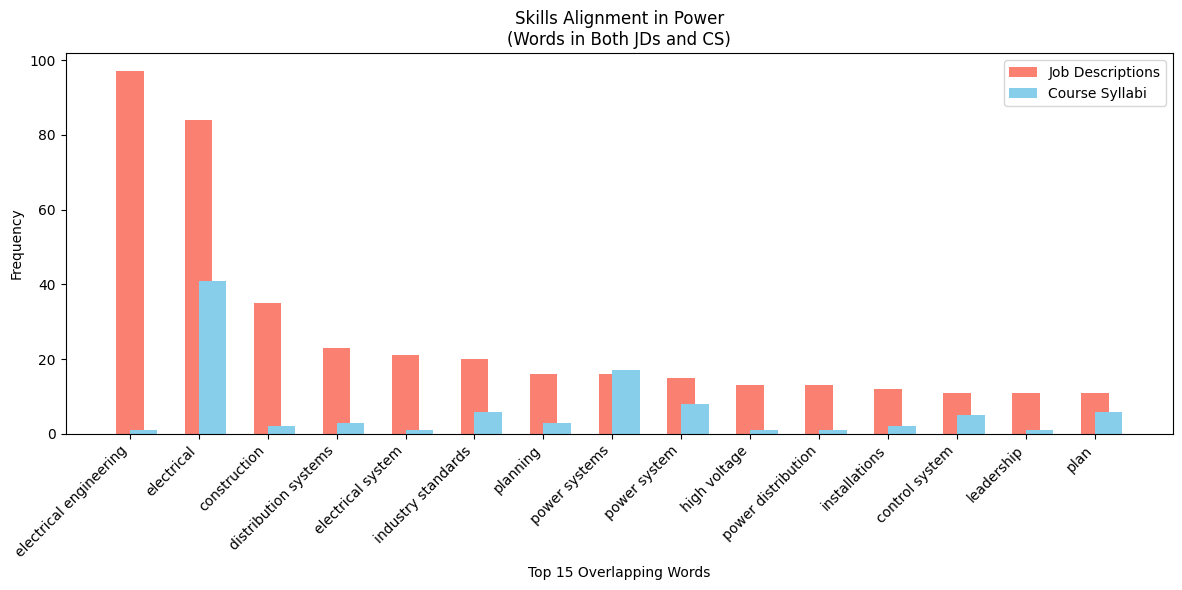

In [257]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

thematic_list = list(num_topics_dict.keys())

for thematic in thematic_list:
    # Extract words
    jd_words = jobs_df[jobs_df['Thematic'] == thematic]['cleaned_description'].dropna().str.split(", ").explode().tolist()
    cs_words = courses_df[courses_df['Thematic'] == thematic]['cleaned_description'].dropna().str.split(", ").explode().tolist()
    
    # Find overlapping words and their frequencies
    overlap = set(jd_words) & set(cs_words)
    overlap_counts_jd = Counter({word: jd_words.count(word) for word in overlap})
    overlap_counts_cs = Counter({word: cs_words.count(word) for word in overlap})
    
    # Get top 10 overlapping words (sorted by JD frequency)
    top_overlap = overlap_counts_jd.most_common(15)
    top_words = [word for word, freq in top_overlap]
    jd_freq = [overlap_counts_jd[word] for word in top_words]
    cs_freq = [overlap_counts_cs[word] for word in top_words]
    
    # Create and display a table
    overlap_df = pd.DataFrame({
        'Word': top_words,
        'JD Frequency': jd_freq,
        'CS Frequency': cs_freq,
        'Frequency Difference': [jd - cs for jd, cs in zip(jd_freq, cs_freq)]
    })
    
    print(f"\n{'-'*50}")
    print(f"Thematic Area: {thematic.upper()}")
    print(f"{'-'*50}")
    print(overlap_df.to_string(index=False))  # Print table without row indices
    
    # Plot the graph
    plt.figure(figsize=(12, 6))
    x = range(len(top_words))
    plt.bar(x, jd_freq, width=0.4, label='Job Descriptions', color='salmon', align='center')
    plt.bar(x, cs_freq, width=0.4, label='Course Syllabi', color='skyblue', align='edge')
    
    plt.xlabel("Top 15 Overlapping Words")
    plt.ylabel("Frequency")
    plt.title(f"Skills Alignment in {thematic.capitalize()}\n(Words in Both JDs and CS)")
    plt.xticks(x, top_words, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()



TOP OVERLAPPING SKILLS BETWEEN JOBS AND COURSES


NameError: name 'num_topics_dict' is not defined